In [1]:
# project: p6
# submitter: xyang467
# partner: none
# hours: 10

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.pipeline import Pipeline
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import PolynomialFeatures

In [3]:
#Q1
df = gpd.read_file("counties.geojson")
len(df.NAME.values)

72

<AxesSubplot:>

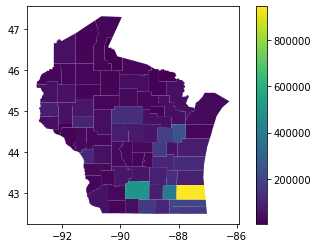

In [4]:
#Q2
fig, ax = plt.subplots()
df.plot(ax=ax,cmap=cm.viridis,column="POP100",legend=True)

In [5]:
#Q3
conn = sqlite3.connect("counties_tracts.db")
counties = pd.read_sql("""SELECT * FROM counties""", conn)
C_AREALAND = df.join(counties.set_index('NAME'), on='NAME')
df["AREALAND"] = C_AREALAND["AREALAND"]
train, test = train_test_split(df,random_state=320,test_size=0.25)
list(test.NAME)

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [6]:
#Q4
model = LinearRegression()
model.fit(train[["AREALAND"]], train["POP100"])
model.score(test[["AREALAND"]], test["POP100"])

0.022002661530554857

In [7]:
#Q5
predict_df = pd.DataFrame({"AREALAND": [500*2.59*1000000]}) 
predict_df["predicted_y"] = model.predict(predict_df)
predict_df.iloc[0,1]

82032.53073541154

In [8]:
#Q6
SUM = pd.read_sql("""
SELECT counties.NAME, SUM(HU100) AS HU100 FROM counties 
INNER JOIN tracts ON tracts.COUNTY = counties.COUNTY
GROUP BY counties.NAME""", conn)
C_HU100 = df.join(SUM.set_index('NAME'), on='NAME')
df["HU100"] = C_HU100["HU100"]
train, test = train_test_split(df,random_state=320,test_size=0.25)
list(test.NAME)

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [9]:
#Q7
train.set_index("NAME").to_dict()['HU100']

{'Walworth County': 51531,
 'Marquette County': 9896,
 'Racine County': 82164,
 'Waupaca County': 25396,
 'Lincoln County': 16784,
 'Washburn County': 12979,
 'Door County': 23966,
 'Waukesha County': 160864,
 'Sheboygan County': 50766,
 'La Crosse County': 48402,
 'Langlade County': 12360,
 'Marathon County': 57734,
 'Jefferson County': 35147,
 'Price County': 11120,
 'Vilas County': 25116,
 'Columbia County': 26137,
 'Ozaukee County': 36267,
 'Fond du Lac County': 43910,
 'Crawford County': 8802,
 'Lafayette County': 7230,
 'Green County': 15856,
 'Marinette County': 30379,
 'Vernon County': 13720,
 'Douglas County': 22825,
 'Rock County': 68422,
 'Iowa County': 10719,
 'Dane County': 216022,
 'Bayfield County': 12999,
 'Polk County': 24248,
 'Trempealeau County': 12619,
 'Brown County': 104371,
 'Washington County': 54695,
 'Chippewa County': 27185,
 'Oconto County': 23537,
 'Richland County': 8868,
 'Portage County': 30054,
 'Sawyer County': 15975,
 'Menominee County': 2253,
 'Barr

In [10]:
#Q8
m2 = LinearRegression()
scores = cross_val_score(m2, train[["HU100"]], train["POP100"])
np.mean(scores)

0.9652534544116037

In [11]:
#Q9
scores.std()

0.03704265206670459

In [12]:
#Q10
m2.fit(train[["HU100"]], train["POP100"])
f"POP100 = {round(m2.coef_[0],2)}*HU100 + {round(m2.intercept_, 2)}"

'POP100 = 2.39*HU100 + -7910.46'

Text(216022, 488073, 'Dane')

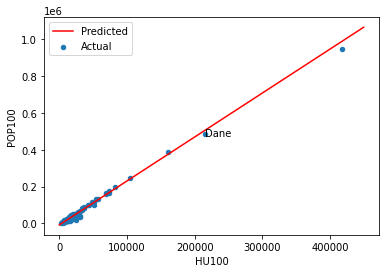

In [13]:
#Q11
predict_df = pd.DataFrame({"HU100": range(1, 450000)})
predict_df["predicted_y"] = m2.predict(predict_df)
ax = predict_df.plot.line(x="HU100", y="predicted_y",label="Predicted", color="red")
df.plot.scatter(x="HU100", y="POP100", ax=ax, label="Actual")
ax.text(df.HU100[df.NAME == "Dane County"].values[0], df.POP100[df.NAME == "Dane County"].values[0],"Dane", va="center", ha="left")

In [14]:
#Q12
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])
((A>=2)&(A<=5)).astype(int).sum()

12

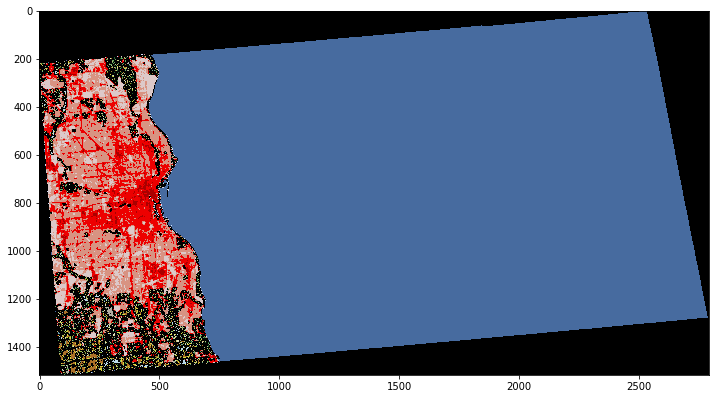

In [15]:
#Q13
land = rasterio.open("zip://../p6/land.zip!wi.tif")
Milwaukee = df[df["NAME"]== "Milwaukee County"]
matrix, _ = mask(land, Milwaukee.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]
c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(matrix, vmin=0, vmax=255,cmap=custom_cmap)

In [16]:
#Q14
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}
(matrix == land_use["open_water"]).astype(int).sum()/ (matrix >0).astype(int).sum()

0.7963037455950543

<AxesSubplot:xlabel='Crops Cells in County', ylabel='POP100'>

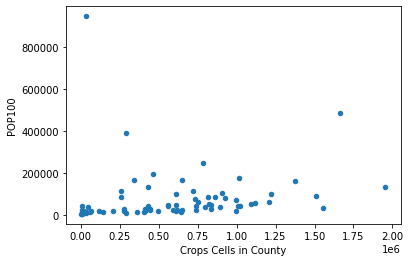

In [17]:
#Q15
#What is the Relationship Between POP100 and crops
df = df.to_crs(land.crs)
def crop_count(county):
    matrix, _ = mask(land, df[df["NAME"]== county]["geometry"], crop=True)
    matrix = matrix[0]
    return (matrix == land_use["crops"]).astype(int).sum()
df['count'] = df['NAME'].apply(crop_count)
df.plot.scatter(x='count', y='POP100',xlabel = "Crops Cells in County")

Text(0, 0.5, 'R^2 Score')

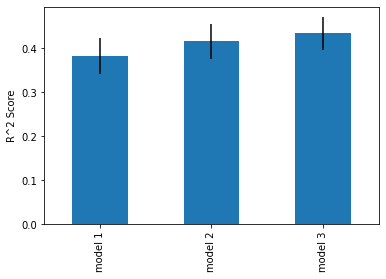

In [18]:
#Q16
tract = gpd.read_file("tracts.geojson")
tract = tract.to_crs(land.crs)

developed_high = []
developed_med = []
developed_low = []
developed_open = []
for i in range(len(tract)):
    matrix, _ = mask(land, tract[tract.index == i]["geometry"], crop=True)
    matrix = matrix[0]
    developed_high.append((matrix == land_use["developed_high"]).astype(int).sum())
    developed_med.append((matrix == land_use["developed_med"]).astype(int).sum())
    developed_low.append((matrix == land_use["developed_low"]).astype(int).sum())
    developed_open.append((matrix == land_use["developed_open"]).astype(int).sum())
tract['developed_high'] = developed_high
tract['developed_med'] = developed_med
tract['developed_low'] = developed_low
tract['developed_open'] = developed_open

train, test = train_test_split(tract,random_state=320)
#model 1: simple linear regression 
m1 = LinearRegression()
scores1 = cross_val_score(m1, train[['developed_med']], train["POP100"])

#model 2: simple linear regression with Polynomial degree 2
m2 = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LinearRegression())
])
scores2 = cross_val_score(m2, train[['developed_med']], train["POP100"])

#model 3: multi-linear regression 
m3 = LinearRegression()
scores3 = cross_val_score(m3, train[['developed_high', 'developed_med','developed_low', 'developed_open']],
                          train["POP100"])
avg = pd.Series({"model 1": scores1.mean(), "model 2": scores2.mean(),"model 3": scores3.mean()})
std = pd.Series({"model 1": scores1.std(), "model 2": scores2.std(),"model 3": scores3.std()})
ax = avg.plot.bar(yerr=std)
ax.set_ylabel("R^2 Score")

In [19]:
#Q17
#I would recommend m3 (multi-linear regression)
#Because 1. it has highest scores among three models
#        2. it has smallest variance among three models
#        3. the model is simple, without Polynomial, only 4 input variables.
m3.fit(train[['developed_high', 'developed_med','developed_low', 'developed_open']], train["POP100"])
m3.score(test[['developed_high', 'developed_med','developed_low', 'developed_open']], test["POP100"])

0.39221150680164873